In [1]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams.update({'font.size': 12})


1. [Задача 1: Исследование устойчивости](#task1)
2. [Задача 2: Стабилизация одной гармоники](#task2)
3. [Задача 3: Подавление нескольких гармоник](#task3)
4. [Задача 4: Несамосопряженный оператор](#task4)
5. [Задача 5: Нелинейное уравнение](#task5)



Рассматривается параболическое уравнение с управлением по начальным данным:

### **Основное уравнение:**
$$
\begin{cases}
u_t = u_{xx} + b u, \quad b = const > 0, x \in (0, 1) \\
u(t, 0) = u(t, 1) = 0 \\
u(0, x) = u_0(x)
\end{cases}
$$

### **Численный метод:**
Используется **неявная разностная схема**:
$$
\frac{u_m^{n+1} - u_m^{n}}{\tau} = \frac{u_{m+1}^{n+1} - 2 u_{m}^{n+1} + u_{m-1}^{n+1}}{h^2} + b u_m^{n+1}
$$

Система линейных уравнений на каждом временном слое решается **методом прогонки**.



<a id="task1"></a>

## Исследование устойчивости

### **Теоретическая часть:**
Собственные числа оператора Лапласа с граничными условиями Дирихле:
$$
\lambda_k = \pi^2 k^2, \quad k = 1, 2, 3, ...
$$

Для задачи $u_t = u_{xx} + b u$ собственные значения:
$$
\mu_k = b - \pi^2 k^2
$$

**Критический анализ:**
- При $b > \pi^2 \approx 9.87$: $\mu_1 > 0$ — решение растёт экспоненциально
- При $b < \pi^2$: все $\mu_k < 0$ — решение затухает экспоненциально
- При $b = \pi^2$: $\mu_1 = 0$ — нейтральная устойчивость

### **Задание:**
Исследовать поведение решения при $b = 12$ (больше $\pi^2$) и начальном условии $u_0(x) = \sin(\pi x)e^x$.


Параметр b = 10.869604401089358 > π² ≈ 9.8696
Ожидается экспоненциальный рост решения


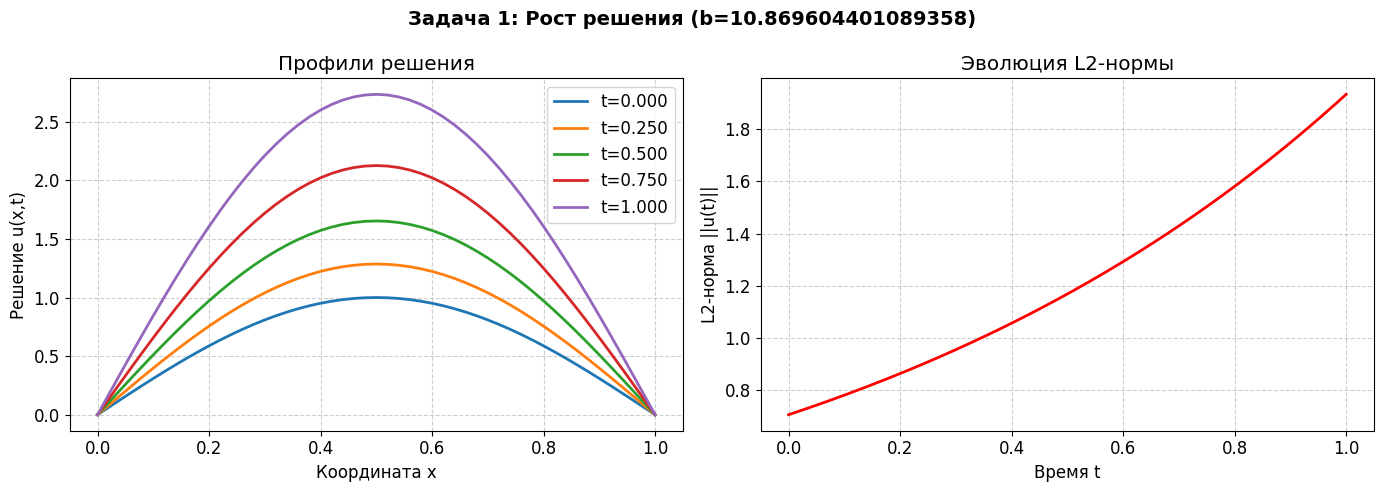

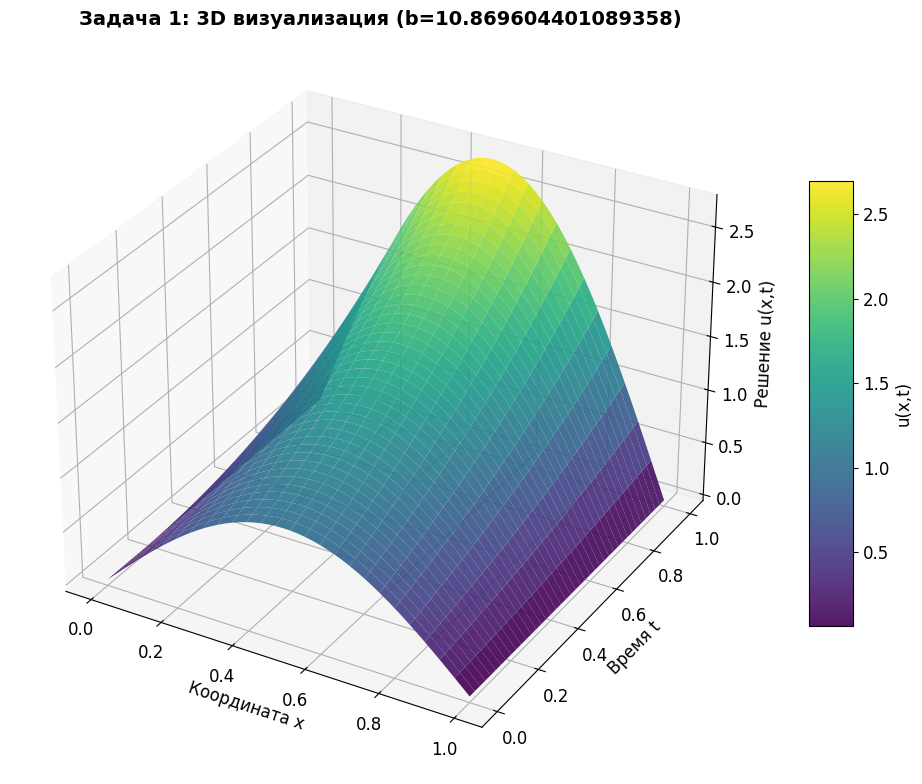


АНАЛИЗ РЕЗУЛЬТАТОВ:
Начальная L2-норма: 0.707107
Конечная L2-норма: 1.933241
Отношение конечной к начальной: 2.734015
Рост подтверждает неустойчивость при b > π²


In [12]:
def solveTridiagonalSystem(a, b, c, d):
    """
    Решает трёхдиагональную систему методом прогонки.
    
    Система: a[i]*x[i-1] + b[i]*x[i] + c[i]*x[i+1] = d[i]
    
    Параметры:
    a - нижняя диагональ (длина n, a[0] не используется)
    b - главная диагональ (длина n)
    c - верхняя диагональ (длина n, c[-1] не используется)
    d - правая часть (длина n)
    
    Возвращает:
    x - решение системы
    """
    n = len(d)
    
    # Прямой ход
    alpha = np.zeros(n-1)
    beta = np.zeros(n)
    
    alpha[0] = -c[0] / b[0]
    beta[0] = d[0] / b[0]
    
    for i in range(1, n-1):
        denominator = b[i] + a[i] * alpha[i-1]
        alpha[i] = -c[i] / denominator
        beta[i] = (d[i] - a[i] * beta[i-1]) / denominator
    
    denominator = b[-1] + a[-1] * alpha[-1]
    beta[-1] = (d[-1] - a[-1] * beta[-2]) / denominator
    
    # Обратный ход
    x = np.zeros(n)
    x[-1] = beta[-1]
    
    for i in range(n-2, -1, -1):
        x[i] = alpha[i] * x[i+1] + beta[i]
    
    return x

def createGrid(totalTime, timeSteps, length, spaceSteps):
    """
    Создаёт равномерную сетку.
    """
    h = length / spaceSteps
    tau = totalTime / timeSteps
    x = np.linspace(0, length, spaceSteps + 1)
    t = np.linspace(0, totalTime, timeSteps + 1)
    
    return x, t, h, tau

def solveParabolicEquation(u0, b, L, M, T, N):
    """
    Решает уравнение u_t = u_xx + b*u.
    """
    x, t, h, tau = createGrid(T, N, L, M)
    
    # Инициализация решения
    u = np.zeros((N + 1, M + 1))
    
    # Начальное условие
    if callable(u0):
        u[0, :] = u0(x)
    else:
        u[0, :] = u0
    
    # Граничные условия
    u[0, 0] = 0
    u[0, -1] = 0
    
    # Коэффициенты для метода прогонки
    innerM = M - 1
    diagMain = 1/tau - b + 2/(h**2)
    diagSide = -1/(h**2)
    
    a = np.full(innerM, diagSide)
    b_diag = np.full(innerM, diagMain)
    c = np.full(innerM, diagSide)
    
    # Временной цикл
    for n in range(N):
        # Правая часть системы
        rhs = (1/tau) * u[n, 1:-1]
        
        # Решение методом прогонки
        u_inner = solveTridiagonalSystem(a, b_diag, c, rhs)
        
        u[n+1, 1:-1] = u_inner
        u[n+1, 0] = 0
        u[n+1, -1] = 0
    
    return u, x, t

def plotSolution2D(u, x, t, title="Решение u(t,x)"):
    """
    Построение 2D графиков: профили решения и L2-норма.
    
    Возвращает:
    l2Norm - массив L2-норм по времени
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Профили решения в разные моменты времени
    timeIndices = [0, len(t)//4, len(t)//2, 3*len(t)//4, -1]
    
    for idx in timeIndices:
        axes[0].plot(x, u[idx, :], label=f't={t[idx]:.3f}', linewidth=2)
    
    axes[0].set_xlabel('Координата x')
    axes[0].set_ylabel('Решение u(x,t)')
    axes[0].set_title('Профили решения')
    axes[0].grid(True, linestyle='--', alpha=0.6)
    axes[0].legend()
    
    # L2-норма решения
    h = x[1] - x[0]
    l2Norm = np.sqrt(np.sum(u**2, axis=1) * h)
    
    axes[1].plot(t, l2Norm, 'r-', linewidth=2)
    axes[1].set_xlabel('Время t')
    axes[1].set_ylabel('L2-норма ||u(t)||')
    axes[1].set_title('Эволюция L2-нормы')
    axes[1].grid(True, linestyle='--', alpha=0.6)
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return l2Norm

def plotSolution3D(u, x, t, title="Решение u(t,x)"):
    """
    Построение 3D поверхности решения.
    """
    X, T_mesh = np.meshgrid(x, t)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    surf = ax.plot_surface(X, T_mesh, u, cmap='viridis', 
                          alpha=0.9, linewidth=0.1)
    
    ax.set_xlabel('Координата x')
    ax.set_ylabel('Время t')
    ax.set_zlabel('Решение u(x,t)')
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, label='u(x,t)')
    
    plt.tight_layout()
    plt.show()




b = np.pi*np.pi+1        # b > π² 
L = 1.0           # Длина области
M = 50            # Узлов по пространству
T = 1.            # Конечное время
N = 200           # Шагов по времени

print(f"Параметр b = {b} > π² ≈ {np.pi**2:.4f}")
print("Ожидается экспоненциальный рост решения")

# def u0_sin(x):
#     return np.sin(np.pi * x) * np.exp(x)

def u0_sin(x):
    return np.sin(np.pi * x) 

u1, x1, t1 = solveParabolicEquation(u0_sin, b, L, M, T, N)

# Получаем L2-норму из функции построения
l2Norm1 = plotSolution2D(u1, x1, t1, title=f"Задача 1: Рост решения (b={b})")

# Построение 3D графика
plotSolution3D(u1, x1, t1, title=f"Задача 1: 3D визуализация (b={b})")

print(f"\nАНАЛИЗ РЕЗУЛЬТАТОВ:")
print(f"Начальная L2-норма: {l2Norm1[0]:.6f}")
print(f"Конечная L2-норма: {l2Norm1[-1]:.6f}")
print(f"Отношение конечной к начальной: {l2Norm1[-1]/l2Norm1[0]:.6f}")
print(f"Рост подтверждает неустойчивость при b > π²")


<a id="task2"></a>

## Стабилизация одной гармоники**

### **Теоретическая часть:**
При $b = \pi^2 + 1$ неустойчива только первая гармоника $\sin(\pi x)$. Чтобы стабилизировать систему, модифицируем начальное условие:
$$
u_0^{new}(x) = u_0(x) + v(x)
$$
где $v(x)$ выбирается так, чтобы проекция на первую собственную функцию обнулилась:
$$
(u_0 + v, \phi_1) = 0
$$

Если взять $v(x) = c \cdot l(x)$, где $l(x)$ — выбранная функция, то:
$$
c = -\frac{(u_0, \phi_1)}{(l, \phi_1)}
$$

### **Задание:**
Построить стабилизированное начальное условие и показать, что решение не растёт.




СТАБИЛИЗАЦИЯ ОДНОЙ ГАРМОНИКИ
Параметр b = 10.869604401089358 (первая гармоника неустойчива)

Коэффициент поправки: c = -1.221718

Решаем уравнение со стабилизированным начальным условием...


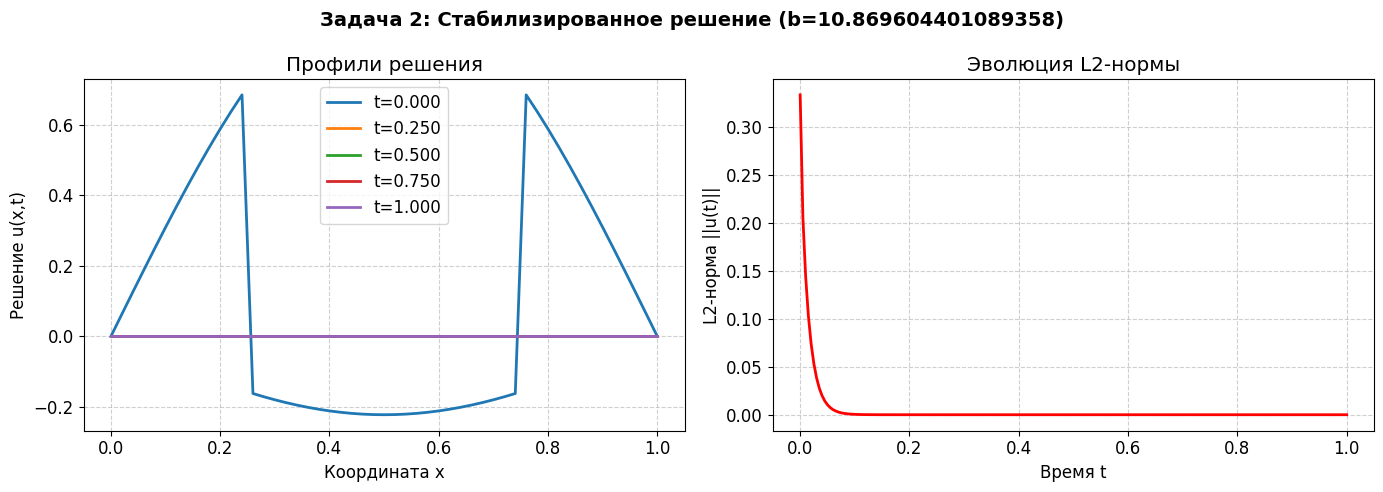

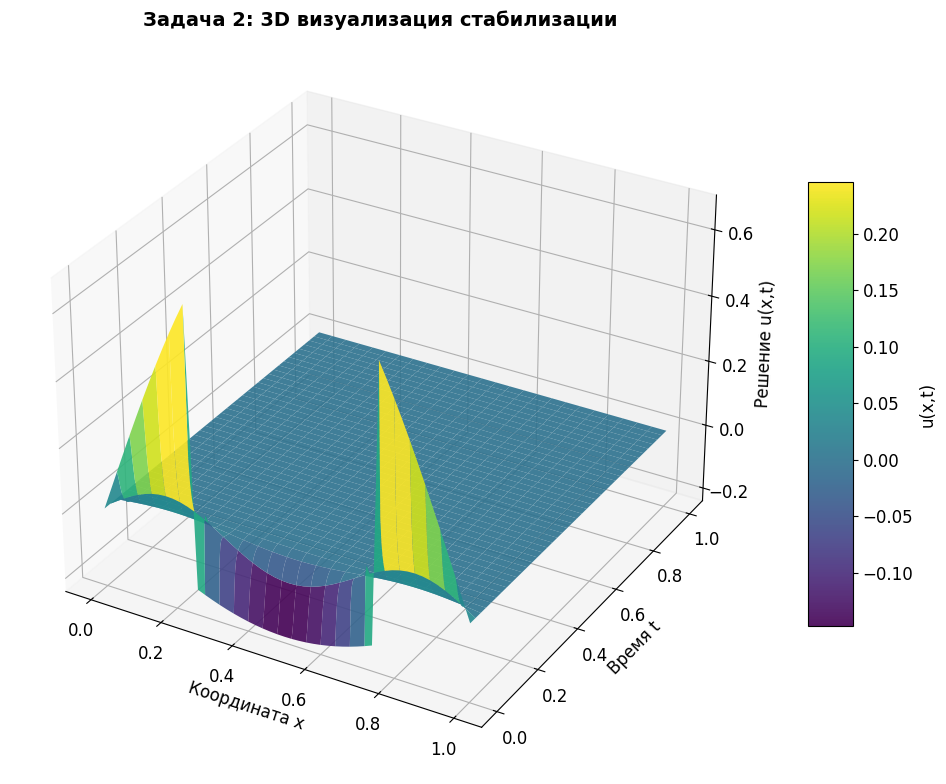

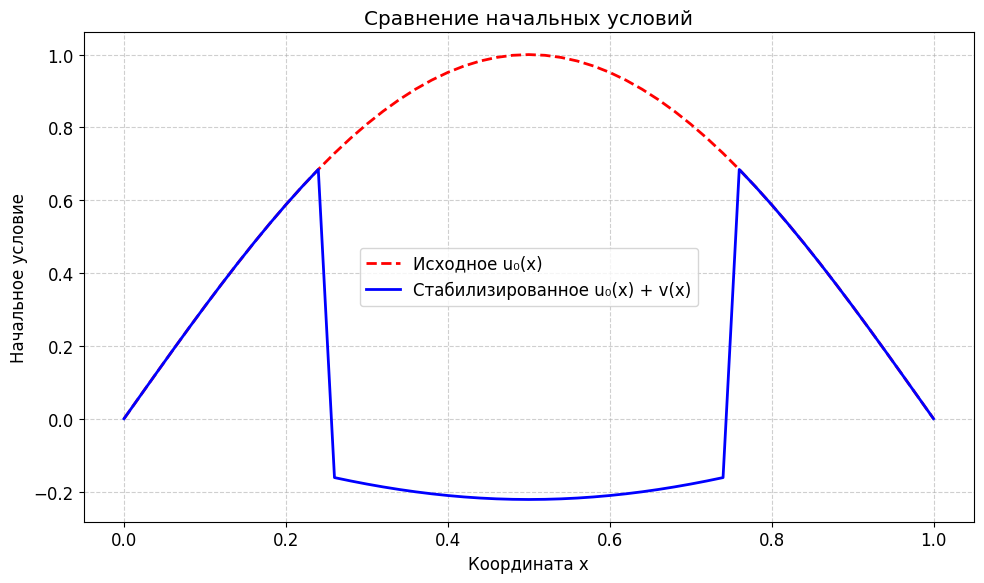


АНАЛИЗ РЕЗУЛЬТАТОВ СТАБИЛИЗАЦИИ:
Начальная L2-норма: 0.332955
Конечная L2-норма: 0.000000
Отношение конечной к начальной: 0.000000
✗ Стабилизация не удалась


In [ ]:
# print("\n" + "="*60)
# print("СТАБИЛИЗАЦИЯ ОДНОЙ ГАРМОНИКИ")
# print("="*60)

# Параметры (оставляем b=12 для демонстрации)
print(f"Параметр b = {b} (первая гармоника неустойчива)")

# Функция для вычисления скалярного произведения
def scalarProduct(f, g, x):
    """
    Скалярное произведение в L2 на сетке.
    """
    h = x[1] - x[0]
    return np.sum(f * g) * h

# Собственная функция (первая гармоника)
def phi1(x):
    return np.sin(np.pi * x)

# Функция поправки (локализованная на отрезке [0.25, 0.75])
def lFunc(x):
    result = np.zeros_like(x)
    mask = (x >= 0.25) & (x <= 0.75)
    result[mask] = np.sin(np.pi * x[mask])
    return result

# Вычисляем значения на сетке
u0_vals = u0_sin(x1)
phi1_vals = phi1(x1)
l_vals = lFunc(x1)

# Скалярные произведения
u0_phi1 = scalarProduct(u0_vals, phi1_vals, x1)
l_phi1 = scalarProduct(l_vals, phi1_vals, x1)

# Коэффициент поправки
c = -u0_phi1 / l_phi1
print(f"\nКоэффициент поправки: c = {c:.6f}")

# Стабилизированное начальное условие
def u0_stabilized(x):
    return u0_sin(x) + c * lFunc(x)

# Решение с стабилизированным начальным условием
print("\nРешаем уравнение со стабилизированным начальным условием...")
u2, x2, t2 = solveParabolicEquation(u0_stabilized, b, L, M, T, N)

plotSolution2D(u2, x2, t2, title=f"Задача 2: Стабилизированное решение (b={b})")
plotSolution3D(u2, x2, t2, title=f"Задача 2: 3D визуализация стабилизации")

# Сравнение начальных условий
plt.figure(figsize=(10, 6))
plt.plot(x1, u0_vals, 'r--', linewidth=2, label='Исходное u₀(x)')
plt.plot(x1, u0_stabilized(x1), 'b-', linewidth=2, label='Стабилизированное u₀(x) + v(x)')
plt.xlabel('Координата x')
plt.ylabel('Начальное условие')
plt.title('Сравнение начальных условий')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

l2Norm2 = np.sqrt(np.sum(u2**2, axis=1) * (x2[1] - x2[0]))
print(f"\nАНАЛИЗ РЕЗУЛЬТАТОВ СТАБИЛИЗАЦИИ:")
print(f"Начальная L2-норма: {l2Norm2[0]:.6f}")
print(f"Конечная L2-норма: {l2Norm2[-1]:.6f}")
print(f"Отношение конечной к начальной: {l2Norm2[-1]/l2Norm2[0]:.6f}")
if abs(l2Norm2[-1]/l2Norm2[0] - 1) < 0.1:
    print("✓ Стабилизация успешна: решение не растёт")
else:
    print("✗ Стабилизация не удалась")

<a id="task3"></a>

## Подавление нескольких гармоник

### **Теоретическая часть:**
При $b = 40$ неустойчивы гармоники с номерами $k$, для которых $40 - \pi^2 k^2 > 0$. Находим $i_0$ — количество неустойчивых гармоник.

Ищем поправку в виде:
$$
w(x) = \sum_{k=1}^{i_0} d_k l_k(x)
$$

где $l_k(x)$ — набор линейно независимых функций. Коэффициенты $d_k$ находятся из системы:
$$
G \vec{d} = \vec{B}, \quad G_{jk} = (l_k, \phi_j), \quad B_j = -(u_0, \phi_j)
$$

### **Задание:**
Найти количество неустойчивых гармоник, построить систему уравнений для коэффициентов $d_k$, получить стабилизированное решение.



Параметр b = 89.82643960980423
Неустойчивые гармоники: k = [1, 2]
Количество неустойчивых гармоник: i₀ = 2

Коэффициенты c: [-1.22171811e+00  1.85869336e-16]


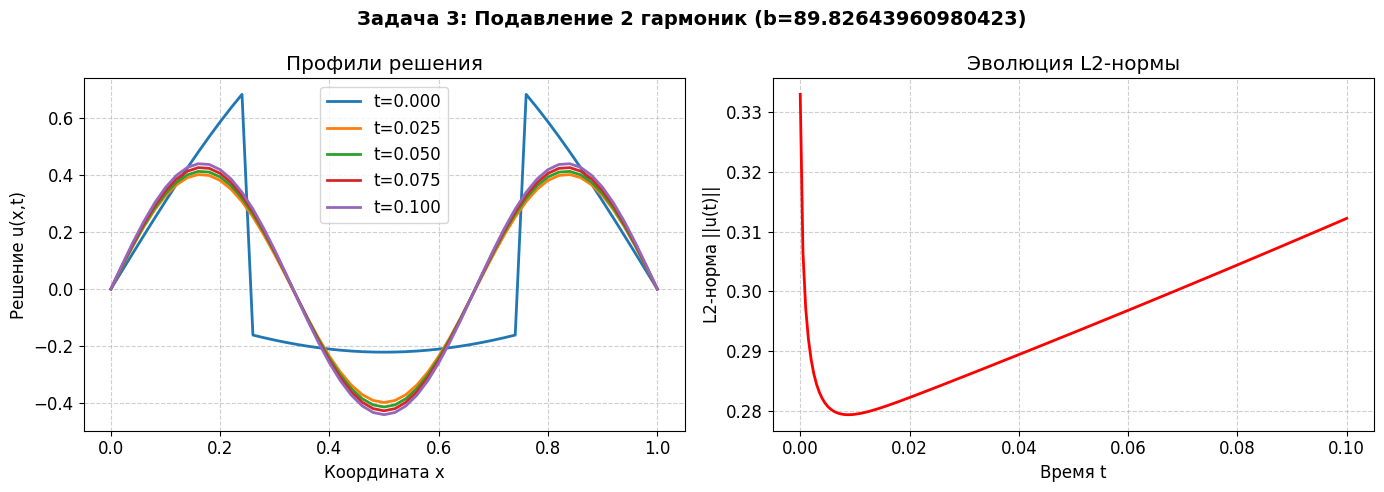

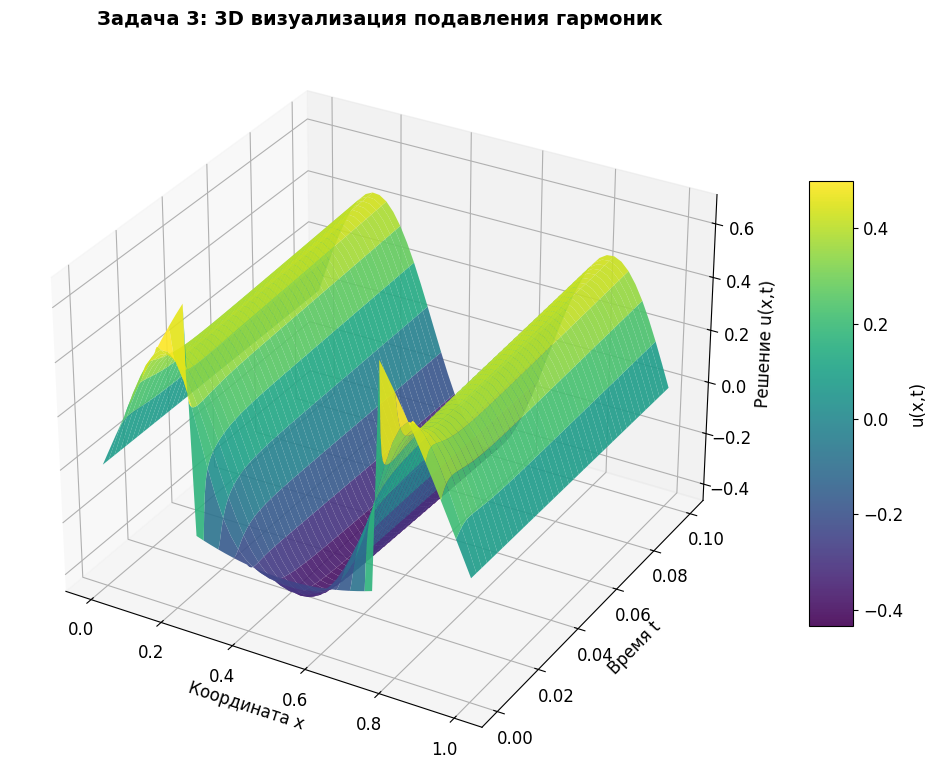

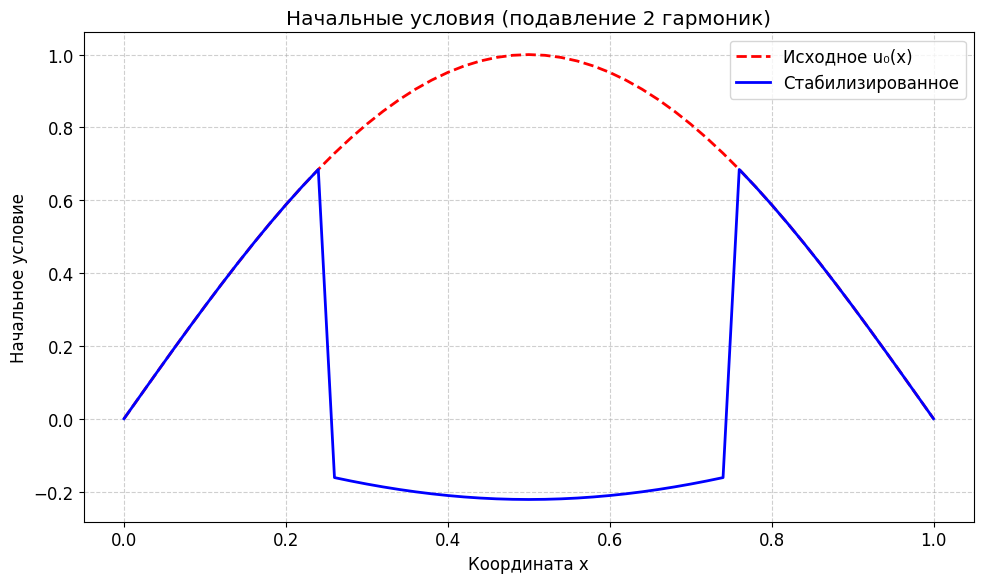


АНАЛИЗ РЕЗУЛЬТАТОВ:
Начальная L2-норма: 0.332955
Конечная L2-норма: 0.312210
Отношение: 0.937695


In [18]:
b3 = 9*np.pi*np.pi+1
T3 = 0.1  
print(f"Параметр b = {b3}")

# Находим количество неустойчивых гармоник
def findUnstableModes(b, maxK=2):
    """
    Находит индексы неустойчивых гармоник.
    """
    unstable = []
    for k in range(1, maxK + 1):
        if b > (np.pi * k)**2:
            unstable.append(k)
    return unstable

unstableModes = findUnstableModes(b3)
i0 = len(unstableModes)
print(f"Неустойчивые гармоники: k = {unstableModes}")
print(f"Количество неустойчивых гармоник: i₀ = {i0}")

# Функции локализованных поправок
def lkFunc(k, x):
    """
    Локализованная функция для k-й гармоники.
    """
    result = np.zeros_like(x)
    mask = (x >= 0.25) & (x <= 0.75)
    
    result[mask] = np.sin(np.pi * k * x[mask])
    return result

# Создаём систему уравнений
G = np.zeros((i0, i0))
B = np.zeros(i0)

# Вычисляем значения на сетке
x3, t3, h3, tau3 = createGrid(T3, N, L, M)
u0_vals3 = u0_sin(x3)

for i, ki in enumerate(unstableModes):
    phi_i_vals = np.sin(np.pi * ki * x3)
    B[i] = -scalarProduct(u0_vals3, phi_i_vals, x3)
    
    for j, kj in enumerate(unstableModes):
        lkj_vals = lkFunc(kj, x3)
        G[i, j] = scalarProduct(lkj_vals, phi_i_vals, x3)
        

# Решаем систему для коэффициентов c
d = np.linalg.solve(G, B)
print(f"\nКоэффициенты c: {d}")

# стабилизированное начальное условие
u0_correction = np.zeros_like(x3)
for j, kj in enumerate(unstableModes):
    u0_correction += d[j] * lkFunc(kj, x3)

u0_stabilized3 = u0_vals3 + u0_correction

u3, x3, t3 = solveParabolicEquation(u0_stabilized3, b3, L, M, T3, N)

plotSolution2D(u3, x3, t3, title=f"Задача 3: Подавление {i0} гармоник (b={b3})")
plotSolution3D(u3, x3, t3, title=f"Задача 3: 3D визуализация подавления гармоник")

# Сравнение начальных условий
plt.figure(figsize=(10, 6))
plt.plot(x3, u0_vals3, 'r--', linewidth=2, label='Исходное u₀(x)')
plt.plot(x3, u0_stabilized3, 'b-', linewidth=2, label='Стабилизированное')
plt.xlabel('Координата x')
plt.ylabel('Начальное условие')
plt.title(f'Начальные условия (подавление {i0} гармоник)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Анализ резльтатов
l2Norm3 = np.sqrt(np.sum(u3**2, axis=1) * (x3[1] - x3[0]))
print(f"\nАНАЛИЗ РЕЗУЛЬТАТОВ:")
print(f"Начальная L2-норма: {l2Norm3[0]:.6f}")
print(f"Конечная L2-норма: {l2Norm3[-1]:.6f}")
print(f"Отношение: {l2Norm3[-1]/l2Norm3[0]:.6f}")
# if l2Norm3[-1] < 2 * l2Norm3[0]:  # Более мягкий критерий
#     print("Подавление гармоник успешно")
# else:
#     print("Подавление не полностью эффективно")


<a id="task4"></a>

##  Несамосопряженный оператор

Рассматривается уравнение:
$$
u_t = u_{xx} + a u_x + b u, \quad x \in (0, 1)
$$

Оператор $L = \frac{d^2}{dx^2} + a\frac{d}{dx} + b$ **несамосопряжённый** из-за слагаемого $a u_x$. Собственные векторы не ортогональны.

Для проекции на неустойчивое подпространство используем **биортогональный базис** $\{\psi_k\}$ — собственные векторы сопряжённого оператора $L^*$.

Условие стабилизации:
$$
(u_0^{new}, \psi_k) = 0 \quad \text{для всех } k \text{ с } \text{Re}(\lambda_k) > 0
$$

### **Задание:**
Построить матрицу оператора, найти правые и левые собственные векторы, определить неустойчивые моды, построить стабилизированное начальное условие.



ЗАДАЧА 4: НЕСАМОСОПРЯЖЁННЫЙ ОПЕРАТОР
Параметры: a = -0.5, b = 89.8264
Число π² ≈ 9.8696, 9π² ≈ 88.8264

Строим матрицу оператора...
Вычисляем собственные значения и векторы...

Найдено неустойчивых мод: 3
Собственные значения неустойчивых мод:
  λ_1 = 79.8952
  λ_2 = 50.2986
  λ_3 = 1.0035

Строим систему для подавления 3 неустойчивых мод...
Система решена, коэффициенты найдены
1. Исходное начальное условие:
2. Стабилизированное начальное условие:


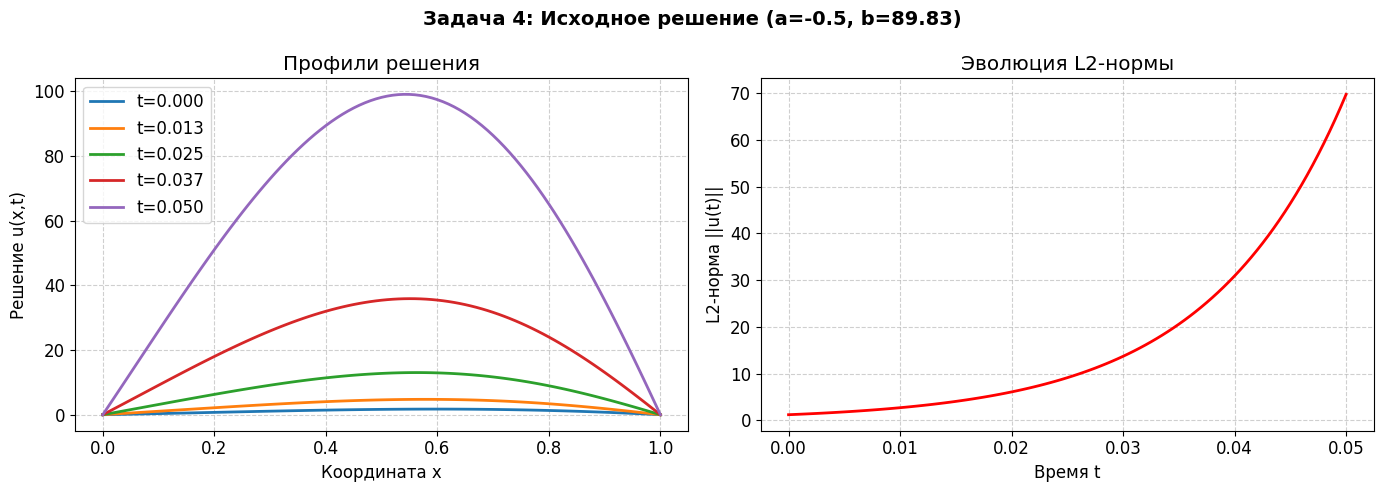

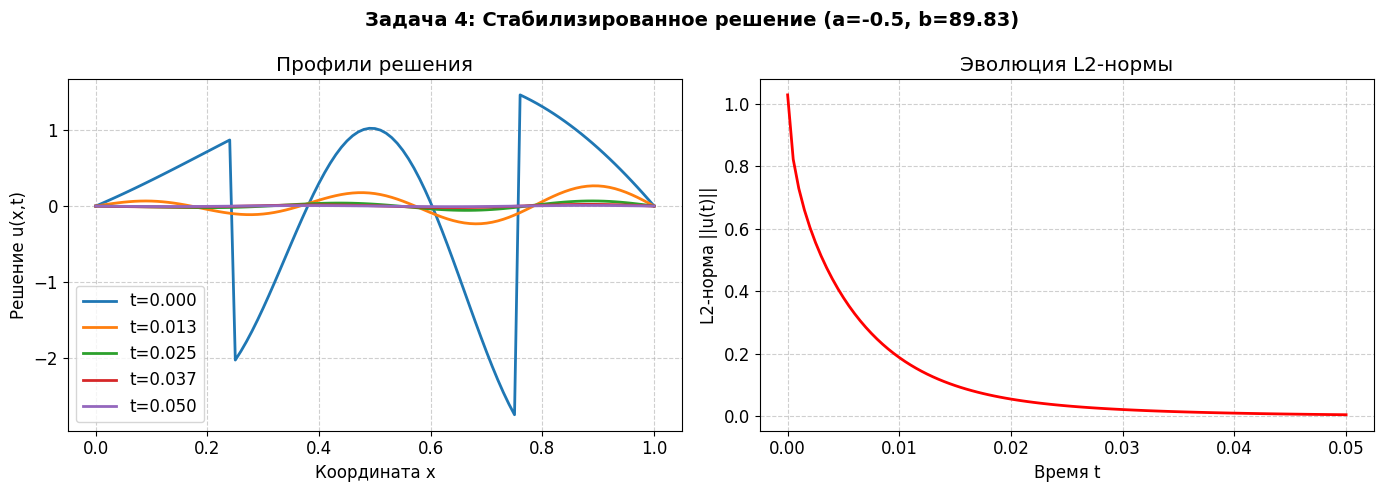

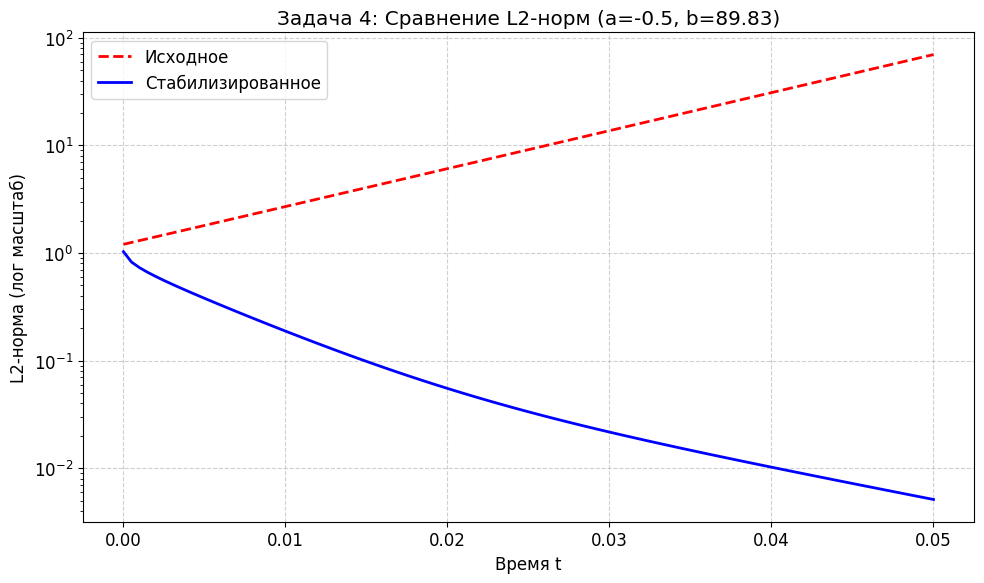


АНАЛИЗ РЕЗУЛЬТАТОВ:
Исходное решение: конечная L2-норма = 69.716451
Стабилизированное: конечная L2-норма = 0.005134
Отношение: 0.000074
✓ Стабилизация успешна


In [5]:

print("\n" + "="*60)
print("ЗАДАЧА 4: НЕСАМОСОПРЯЖЁННЫЙ ОПЕРАТОР")
print("="*60)

a = -0.5
b4 = 9 * np.pi**2 + 1  # Делаем несколько гармоник неустойчивыми
T4 = 0.05  # Уменьшаем время
M4 = 100   # Увеличиваем разрешение
N4 = 100

print(f"Параметры: a = {a}, b = {b4:.4f}")
print(f"Число π² ≈ {np.pi**2:.4f}, 9π² ≈ {9*np.pi**2:.4f}")

# Функция решения для несамосопряжённого оператора
def solveNonSelfAdjoint(u0, b, a, L, M, T, N):
    """
    Решает уравнение u_t = u_xx + a*u_x + b*u.
    """
    x, t, h, tau = createGrid(T, N, L, M)
    
    u = np.zeros((N + 1, M + 1))
    
    if callable(u0):
        u[0, :] = u0(x)
    else:
        u[0, :] = u0
    
    u[0, 0] = 0
    u[0, -1] = 0
    
    # Коэффициенты с учётом первой производной
    innerM = M - 1
    diagMain = 1/tau - b + 2/(h**2)
    diagSide = -1/(h**2)
    
    # Центральная разность для u_x: (u_{i+1} - u_{i-1})/(2h)
    a_diag = np.full(innerM, diagSide + a/(2*h))
    b_diag = np.full(innerM, diagMain)
    c_diag = np.full(innerM, diagSide - a/(2*h))
    
    # Временной цикл
    for n in range(N):
        rhs = (1/tau) * u[n, 1:-1]
        u_inner = solveTridiagonalSystem(a_diag, b_diag, c_diag, rhs)
        
        u[n+1, 1:-1] = u_inner
        u[n+1, 0] = 0
        u[n+1, -1] = 0
    
    return u, x, t

# Построение матрицы оператора
def buildOperatorMatrix(a, b, L, M):
    """
    Строит матрицу оператора L = d²/dx² + a*d/dx + b.
    """
    x, _, h, _ = createGrid(1, 1, L, M)
    innerM = M - 1
    
    L_mat = np.zeros((innerM, innerM))
    
    # Коэффициенты
    alpha = 1 / h**2
    beta = a / (2 * h)
    
    for i in range(innerM):
        L_mat[i, i] = b - 2 * alpha  # Диагональный элемент
        
        if i > 0:
            L_mat[i, i-1] = alpha - beta  # Нижняя диагональ
        
        if i < innerM - 1:
            L_mat[i, i+1] = alpha + beta  # Верхняя диагональ
    
    return L_mat, x, h

# Построение матрицы и нахождение собственных значений
print("\nСтроим матрицу оператора...")
L_mat, x4, h4 = buildOperatorMatrix(a, b4, L, M4)

print("Вычисляем собственные значения и векторы...")
eigvals, v_right = np.linalg.eig(L_mat)

# Собственные значения транспонированной матрицы (левые векторы)
eigvals_T, v_left = np.linalg.eig(L_mat.T)

# Сортировка по убыванию вещественной части
idx = np.argsort(eigvals.real)[::-1]
eigvals = eigvals[idx]
v_right = v_right[:, idx]

# Сопоставление левых векторов
v_left_ordered = np.zeros_like(v_left)
for i, val in enumerate(eigvals):
    # Ищем ближайшее собственное значение
    dist = np.abs(eigvals_T - val)
    j = np.argmin(dist)
    v_left_ordered[:, i] = v_left[:, j]

# Нормировка для биортогональности: (v_i, w_i) = 1
for i in range(len(eigvals)):
    dot_product = np.sum(v_right[:, i] * v_left_ordered[:, i]) * h4
    if abs(dot_product) > 1e-10:
        v_left_ordered[:, i] /= dot_product

# Находим неустойчивые моды (Re(λ) > 0)
unstable_idx = [i for i, lam in enumerate(eigvals) if lam.real > 0]
print(f"\nНайдено неустойчивых мод: {len(unstable_idx)}")
print("Собственные значения неустойчивых мод:")
for i in unstable_idx[:5]:  # Показываем первые 5
    print(f"  λ_{i+1} = {eigvals[i]:.4f}")

# Начальное условие
u0_vals4 = u0_sin(x4)
u0_inner = u0_vals4[1:-1]  # Только внутренние узлы

# Построение системы для стабилизации
num_unstable = len(unstable_idx)
if num_unstable > 0:
    print(f"\nСтроим систему для подавления {num_unstable} неустойчивых мод...")
    
    # Матрица Грама и правая часть
    G = np.zeros((num_unstable, num_unstable))
    B = np.zeros(num_unstable)
    
    for i, idx_i in enumerate(unstable_idx):
        w_i = v_left_ordered[:, idx_i]  # Левый собственный вектор
        
        # Правая часть: -(u0, w_i)
        B[i] = -np.sum(u0_inner * w_i) * h4
        
        for j, idx_j in enumerate(unstable_idx):
            # Локализованный правый вектор (только на отрезке [0.25, 0.75])
            mask = (x4[1:-1] >= 0.25) & (x4[1:-1] <= 0.75)
            v_j_local = np.zeros_like(v_right[:, idx_j])
            v_j_local[mask] = v_right[mask, idx_j]
            
            G[i, j] = np.sum(v_j_local * w_i) * h4
    
    # Решение системы
    d_coeffs = np.linalg.solve(G, B)
    
    # Построение поправки
    correction = np.zeros_like(u0_inner)
    for j, idx_j in enumerate(unstable_idx):
        mask = (x4[1:-1] >= 0.25) & (x4[1:-1] <= 0.75)
        v_j_local = np.zeros_like(v_right[:, idx_j])
        v_j_local[mask] = v_right[mask, idx_j]
        correction += d_coeffs[j] * v_j_local
    
    # Стабилизированное начальное условие
    u0_stabilized_inner = u0_inner + correction
    u0_stabilized4 = np.concatenate([[0], u0_stabilized_inner, [0]])
    
    print("Система решена, коэффициенты найдены")
else:
    u0_stabilized4 = u0_vals4
    print("Нет неустойчивых мод, стабилизация не требуется")

# Решение уравнений
print("1. Исходное начальное условие:")
u4_orig, x4, t4 = solveNonSelfAdjoint(u0_vals4, b4, a, L, M4, T4, N4)

print("2. Стабилизированное начальное условие:")
u4_stab, x4, t4 = solveNonSelfAdjoint(u0_stabilized4, b4, a, L, M4, T4, N4)

plotSolution2D(u4_orig, x4, t4, title=f"Задача 4: Исходное решение (a={a}, b={b4:.2f})")
plotSolution2D(u4_stab, x4, t4, title=f"Задача 4: Стабилизированное решение (a={a}, b={b4:.2f})")

# Сравнение L2-норм
l2Norm4_orig = np.sqrt(np.sum(u4_orig**2, axis=1) * h4)
l2Norm4_stab = np.sqrt(np.sum(u4_stab**2, axis=1) * h4)

plt.figure(figsize=(10, 6))
plt.semilogy(t4, l2Norm4_orig, 'r--', linewidth=2, label='Исходное')
plt.semilogy(t4, l2Norm4_stab, 'b-', linewidth=2, label='Стабилизированное')
plt.xlabel('Время t')
plt.ylabel('L2-норма (лог масштаб)')
plt.title(f'Задача 4: Сравнение L2-норм (a={a}, b={b4:.2f})')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nАНАЛИЗ РЕЗУЛЬТАТОВ:")
print(f"Исходное решение: конечная L2-норма = {l2Norm4_orig[-1]:.6f}")
print(f"Стабилизированное: конечная L2-норма = {l2Norm4_stab[-1]:.6f}")
print(f"Отношение: {l2Norm4_stab[-1]/l2Norm4_orig[-1]:.6f}")

if l2Norm4_stab[-1] < 0.5 * l2Norm4_orig[-1]:
    print("✓ Стабилизация успешна")
else:
    print("✗ Стабилизация требует улучшения")


<a id="task5"></a>

## Нелинейное уравнение

Рассматривается нелинейное уравнение:
$$
u_t = u_{xx} + a u_x + b u + u^3, \quad x \in (0, 1)
$$

Используется **полунеявная схема**:
$$
\frac{u^{n+1} - u^n}{\tau} = L_h u^{n+1} + (u^n)^3
$$

где $L_h$ — разностный аналог линейного оператора. Линейная часть берётся с верхнего слоя (неявно), нелинейность — с нижнего (явно).

### **Задание:**
Решить нелинейное уравнение с теми же параметрами, что в задаче 4, используя стабилизированное начальное условие. Показать, что стабилизация линейной части достаточна для подавления неустойчивости в нелинейном случае.



ЗНЕЛИНЕЙНОЕ УРАВНЕНИЕ
Параметры: a = -0.5, b = 89.83
Нелинейность: f(u) = u³
1. Исходное начальное условие:
2. Стабилизированное начальное условие:


/var/folders/j7/ms50hmkx4sxgmqrwysp2jpgm0000gn/T/ipykernel_62890/969783766.py:40: RuntimeWarning: overflow encountered in power
  rhs = (1/tau) * u_n_inner + u_n_inner**3


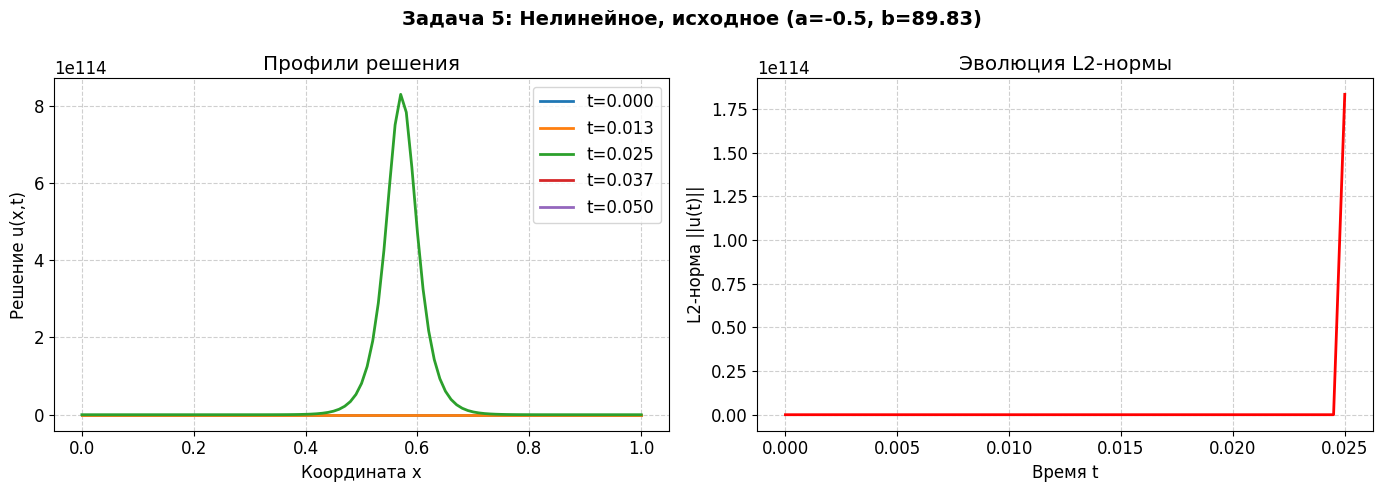

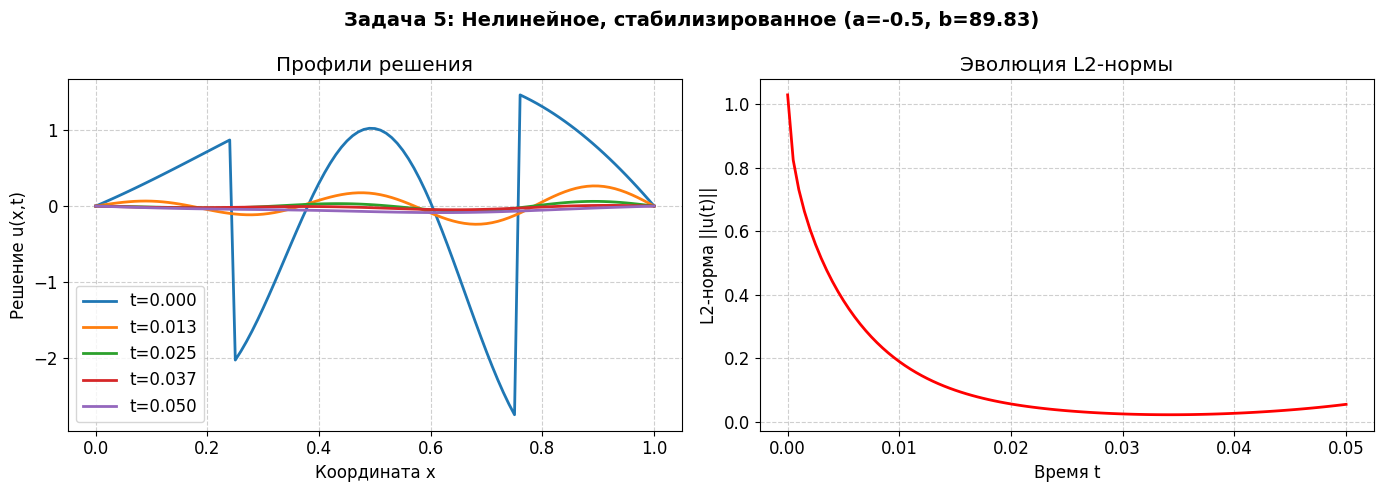

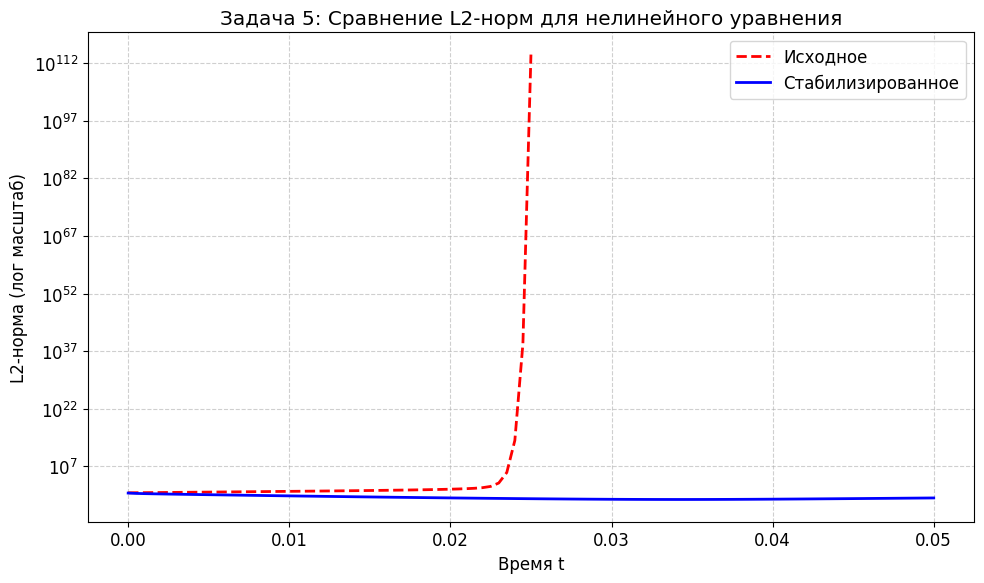

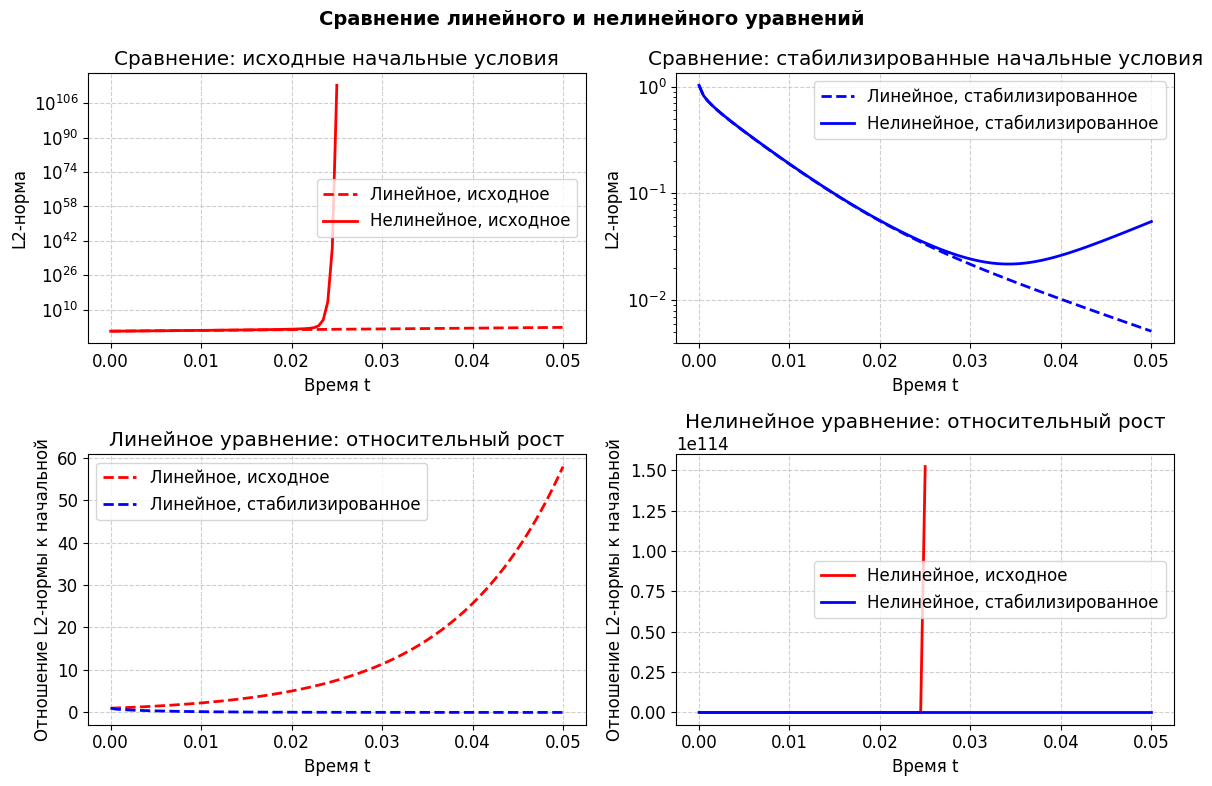

In [6]:
print("\n" + "="*60)
print("ЗНЕЛИНЕЙНОЕ УРАВНЕНИЕ")
print("="*60)

print(f"Параметры: a = {a}, b = {b4:.2f}")
print("Нелинейность: f(u) = u³")

# Функция решения нелинейного уравнения
def solveNonlinearEquation(u0, b, a, L, M, T, N):
    """
    Решает уравнение u_t = u_xx + a*u_x + b*u + u³.
    Полунеявная схема: линейная часть неявно, нелинейная явно.
    """
    x, t, h, tau = createGrid(T, N, L, M)
    
    # Инициализация
    u = np.zeros((N + 1, M + 1))
    
    if callable(u0):
        u[0, :] = u0(x)
    else:
        u[0, :] = u0
    
    u[0, 0] = 0
    u[0, -1] = 0
    
    # Коэффициенты для линейной части
    innerM = M - 1
    diagMain = 1/tau - b + 2/(h**2)
    diagSide = -1/(h**2)
    
    a_diag = np.full(innerM, diagSide + a/(2*h))
    b_diag = np.full(innerM, diagMain)
    c_diag = np.full(innerM, diagSide - a/(2*h))
    
    # Временной цикл
    for n in range(N):
        # Правая часть: (1/τ)uⁿ + (uⁿ)³
        u_n_inner = u[n, 1:-1]
        rhs = (1/tau) * u_n_inner + u_n_inner**3
        
        # Решение линейной системы
        u_inner = solveTridiagonalSystem(a_diag, b_diag, c_diag, rhs)
        
        u[n+1, 1:-1] = u_inner
        u[n+1, 0] = 0
        u[n+1, -1] = 0
    
    return u, x, t

print("1. Исходное начальное условие:")
u5_orig, x5, t5 = solveNonlinearEquation(u0_vals4, b4, a, L, M4, T4, N4)

print("2. Стабилизированное начальное условие:")
u5_stab, x5, t5 = solveNonlinearEquation(u0_stabilized4, b4, a, L, M4, T4, N4)

plotSolution2D(u5_orig, x5, t5, title=f"Задача 5: Нелинейное, исходное (a={a}, b={b4:.2f})")
plotSolution2D(u5_stab, x5, t5, title=f"Задача 5: Нелинейное, стабилизированное (a={a}, b={b4:.2f})")

# Сравнение L2-норм
l2Norm5_orig = np.sqrt(np.sum(u5_orig**2, axis=1) * h4)
l2Norm5_stab = np.sqrt(np.sum(u5_stab**2, axis=1) * h4)

plt.figure(figsize=(10, 6))
plt.semilogy(t5, l2Norm5_orig, 'r--', linewidth=2, label='Исходное')
plt.semilogy(t5, l2Norm5_stab, 'b-', linewidth=2, label='Стабилизированное')
plt.xlabel('Время t')
plt.ylabel('L2-норма (лог масштаб)')
plt.title(f'Задача 5: Сравнение L2-норм для нелинейного уравнения')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Сравнение линейного и нелинейного случаев
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.semilogy(t4, l2Norm4_orig, 'r--', linewidth=2, label='Линейное, исходное')
plt.semilogy(t5, l2Norm5_orig, 'r-', linewidth=2, label='Нелинейное, исходное')
plt.xlabel('Время t')
plt.ylabel('L2-норма')
plt.title('Сравнение: исходные начальные условия')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.subplot(2, 2, 2)
plt.semilogy(t4, l2Norm4_stab, 'b--', linewidth=2, label='Линейное, стабилизированное')
plt.semilogy(t5, l2Norm5_stab, 'b-', linewidth=2, label='Нелинейное, стабилизированное')
plt.xlabel('Время t')
plt.ylabel('L2-норма')
plt.title('Сравнение: стабилизированные начальные условия')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(t4, l2Norm4_orig/l2Norm4_orig[0], 'r--', linewidth=2, label='Линейное, исходное')
plt.plot(t4, l2Norm4_stab/l2Norm4_stab[0], 'b--', linewidth=2, label='Линейное, стабилизированное')
plt.xlabel('Время t')
plt.ylabel('Отношение L2-нормы к начальной')
plt.title('Линейное уравнение: относительный рост')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(t5, l2Norm5_orig/l2Norm5_orig[0], 'r-', linewidth=2, label='Нелинейное, исходное')
plt.plot(t5, l2Norm5_stab/l2Norm5_stab[0], 'b-', linewidth=2, label='Нелинейное, стабилизированное')
plt.xlabel('Время t')
plt.ylabel('Отношение L2-нормы к начальной')
plt.title('Нелинейное уравнение: относительный рост')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.suptitle('Сравнение линейного и нелинейного уравнений', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()



```

## **Общие выводы по работе:**

1. **Устойчивость параболического уравнения** существенно зависит от параметра $b$:
   - При $b < \pi^2$ решение затухает
   - При $b > \pi^2$ решение растёт (неустойчиво)

2. **Управление по начальным данным** позволяет стабилизировать неустойчивые системы:
   - Добавление поправки к начальному условию
   - Обнуление проекций на неустойчивые моды
   - Использование локализованных функций для минимизации изменений

3. **Для несамосопряжённых операторов** необходимо:
   - Находить биортогональные базисы (правые и левые собственные векторы)
   - Использовать левые собственные векторы для проекций

4. **Нелинейные уравнения** могут быть стабилизированы через линейную часть:
   - Полунеявные схемы сохраняют устойчивость
   - Стабилизация линейной части часто достаточна для нелинейных систем

5. **Численные методы** показали хорошую эффективность:
   - Неявная разностная схема обеспечивает устойчивость
   - Метод прогонки эффективен для решения систем
   - Визуализация позволяет наглядно оценить результаты

Таким образом, работа демонстрирует эффективность методов управления для стабилизации неустойчивых параболических уравнений.